# Upwelling velocities notebook

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import cmocean
import os
from datetime import datetime
from matplotlib import gridspec
from salishsea_tools import grid_tools, tidetools, viz_tools, places, utilities

%matplotlib inline
plt.rcParams['font.size'] = 12

### Local functions

In [3]:
def make_pressure_diagram():
    """Quick plotting code for pressure diagram
    """

    # Make figure
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([0.1, 0.8])
    ax.yaxis.set_ticklabels(['$z=-h$', '$z=0$'])

    # Add lines
    x = np.arange(0, 1.01, 0.01)
    ax.plot([0, 1], [0.8, 0.8], 'k--')
    ax.plot([0, 1], [0.1, 0.1], 'k--')
    ax.plot(x, np.sin(2*np.pi*x-1.5)/6 + 0.8, 'k-')
    ax.plot(x, np.sin(2*np.pi*x-1.5)/12 + 0.1, 'k-')

    # Add labels
    ax.arrow(0.5, 0.8, 0, 0.14, head_width=0.01, fc='k')
    ax.arrow(0.5, 0.1, 0, 0.06, head_width=0.01, fc='k')
    ax.arrow(0.24, 0.1, 0, 0.68, head_width=0.01, fc='k')
    ax.arrow(0.48, 0.19, 0, 0.75, head_width=0.01, fc='k')
    ax.text(0.505, 0.86, '$\eta$')
    ax.text(0.505, 0.12, '$\\xi$')
    ax.text(0.245, 0.5, '$\sum_k^0e3t(0)$')
    ax.text(0.485, 0.5, '$\sum_k^0e3t(t)$')

    plt.show()
    
    return

In [14]:
def calc_sigma_surface():
    """Calculate 1022 surface depth
    """
    
    index = abs(rho - 1022).argmin(axis=1)
    p, _, m, n = VVL['gdept_t'].shape
    depth_1022 = np.zeros((p, m, n))
    for t in range(p):
        for j in range(m):
            for i in range(n):
                depth_1022[t, j, i] = VVL['gdept_t'][t, index[t, j, i], j, i]
                
    return depth_1022

### Prepare results

Load run files

In [3]:
# Load run files
results_path = '/data/vdo/MEOPAR/completed-runs/stats-runs2/25apr15'
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
TRC = xr.open_dataset(os.path.join(results_path, 'SalishSea_1h_20150425_20150429_ptrc_T.nc'))
T = xr.open_dataset(os.path.join(results_path, 'SalishSea_1h_20150425_20150429_grid_T.nc'))
U = xr.open_dataset(os.path.join(results_path, 'SalishSea_1h_20150425_20150429_grid_U.nc'))
V = xr.open_dataset(os.path.join(results_path, 'SalishSea_1h_20150425_20150429_grid_V.nc'))
GEM = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
GEM = GEM.sel(time=slice('2015 Apr 25', '2015 Apr 29'))

Define slices and parameters

In [4]:
# Gravitational acceleration
g = 9.81
f = 1e-4

# Define slices
trange = [10, 100]
xrange = [115, 220]
yrange = [500, 675]
tslice = slice(*trange)
xslice = slice(*xrange)
yslice = slice(*yrange)

# Define dims
x = mask.x[xslice].values
y = mask.y[yslice].values

# Define parameters
e3t_0 = mask.e3t_0[..., yslice, xslice].values
gdept_0 = mask.gdept_0[..., yslice, xslice].values
tmask = mask.tmask[0, :, yslice, xslice].values
eta = T.sossheig[tslice, yslice, xslice].values

# Upwelling tracer field
tracer = TRC.mytracer3[tslice, 0, yslice, xslice]
GEM = GEM.isel(time=tslice)

Calculate time-dependent vertical grid, $\rho$, and $\rho=1022$ kg m$^{-3}$ surface

In [5]:
# Obtain the time dependent grid parameters
VVL = grid_tools.calculate_time_dependent_grid(e3t_0[0, ...], tmask, eta, {'e3t_t': e3t_0, 'gdept_t': gdept_0})

# Calculate rho
rho = gsw.rho(T.vosaline[tslice, :, yslice, xslice], T.votemper[tslice, :, yslice, xslice], VVL['gdept_t'])

### Calculate the total pressure field

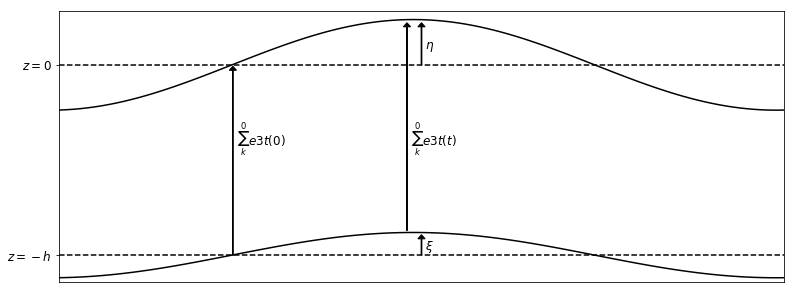

In [8]:
make_pressure_diagram()

$$\xi = \eta - \left(\sum_k^0e3t(t) - \sum_k^0e3t(0)\right)$$

$$p = g\int_{-h}^\eta\rho dz = g\int_{-h+\xi}^\eta\rho dz + g\rho_{deep}\xi$$

### Calculate geostrophic and ageostrophic velocities

$$
\begin{align}
u & = -\frac{1}{f\rho}\frac{\partial p}{\partial y} \\
v & = \frac{1}{f\rho}\frac{\partial p}{\partial x}
\end{align}
$$

$$\mathbf{u}_a = \mathbf{u} - \mathbf{u}_g$$

So let's take a look.

In [6]:
def calc_geostrophic_velocities(idepth):
    """Calculate pressure gradients and geostrophic velocities at idepth
    """

    # Calculate z surface displacement xi
    stretching = VVL['e3t_t'][:, :idepth, ...].sum(axis=1) - e3t_0[:, :idepth, ...].sum(axis=1)
    xi = eta - stretching

    # Define rho at z surface
    rho_bot = rho[:, idepth, ...]
    rho_bot[xi < 0] = rho[:, idepth - 1, ...][xi < 0]

    # Calculate pressure
    pressure = g * ((rho[:, :idepth, ...] * VVL['e3t_t'][:, :idepth, ...]).sum(axis=1) + rho_bot * xi)

    # Calculate the pressure gradient
    dpdy, dpdx = np.gradient(pressure, axis=(1, 2))

    # Extract and unstagger the model velocity fields
    u = U.vozocrtx[tslice, idepth, yslice, xslice].values
    v = V.vomecrty[tslice, idepth, yslice, xslice].values
    u[:, 1:, 1:], v[:, 1:, 1:] = viz_tools.unstagger(u, v)

    # Calculate the geostrophic velocities
    u_g = -1 / (f * rho[:, idepth, ...]) * dpdy / mask.e2t[:, yslice, xslice].values
    v_g = 1 / (f * rho[:, idepth, ...]) * dpdx / mask.e1t[:, yslice, xslice].values

    # Calculate ageostrophic velocities
    u_a = u - u_g
    v_a = v - v_g

    # Filter tides
    GEO = {
        'u': tidetools.filter_timeseries(u),
        'v': tidetools.filter_timeseries(v),
        'u_g': tidetools.filter_timeseries(u_g),
        'v_g': tidetools.filter_timeseries(v_g),
        'u_a': tidetools.filter_timeseries(u_a),
        'v_a': tidetools.filter_timeseries(v_a),
        'eta': tidetools.filter_timeseries(eta),
        'pressure': tidetools.filter_timeseries(pressure),
    }
        
    return GEO

In [31]:
def plotit(t):
    """Plot the pressure and velocity fields.
    """
    
    # Plot parameters
    trange_plot = [0, 90]
    tslice_plot = slice(*trange_plot)
    j, i = places.PLACES['Sisters Islet']['GEM2.5 grid ji']
    j_NEMO, i_NEMO = places.PLACES['Sisters Islet']['NEMO grid ji']
    index = GEM.v_wind[tslice_plot, j, i].values > 0

    # Make plot grid
    axs = []
    caxs = []
    fig = plt.figure(figsize=(14, 25))
    gs = gridspec.GridSpec(5, 4, height_ratios=[1, 5, 5, 5, 5])
    axs.append(fig.add_subplot(gs[0, :]))
    for row, pos in zip(range(1, 5), [0.67, 0.49, 0.31, 0.13]):
        axs.extend([fig.add_subplot(gs[row, col]) for col in range(4)])
        caxs.append(fig.add_axes([0.29, pos, 0.008, 0.15]))

    # Plot wind record
    axs[0].fill_between(GEM.time.values[tslice_plot], GEM.v_wind[tslice_plot, j, i].values, where=index, color='firebrick', interpolate=True)
    axs[0].fill_between(GEM.time.values[tslice_plot], GEM.v_wind[tslice_plot, j, i].values, where=~index, color='darkslategray', interpolate=True)
    axs[0].plot(GEM.time.values[tslice_plot], GEM.v_wind[tslice_plot, j, i].values, 'k-')
    axs[0].plot([GEM.time.values[t], GEM.time.values[t]], [-12, 12], 'k-')
    axs[0].set_xlim([GEM.time.values[trange_plot[0]], GEM.time.values[trange_plot[1]-1]])
    axs[0].set_ylim([-12, 12])
    axs[0].set_title('Alongstrait windspeed at Sisters Islet')
    axs[0].set_ylabel('m/s')
    
    # Plot depths by row
    for row, cax, idepth in zip(range(1, 14, 4), caxs, range(5, 21, 5)):
        
        # Calculate geostrophic velocities
        GEO = calc_geostrophic_velocities(idepth)
        
        # Plot pressure fields
        c = axs[row].contourf(
            x, y, GEO['pressure'][t, ...]*1e-4,
            levels=np.arange(30.97, 30.99, 0.001),
            cmap=cmocean.cm.dense, extend='both',
        )
        fig.colorbar(c, cax=cax, label='dbar')

        # Plot velocity fields
        for col, key_u, key_v in zip(range(1, 4), ['u', 'u_g', 'u_a'], ['v', 'v_g', 'v_a']):
            index = (abs(GEO[key_u][t, ::5, ::5]) > 0.5) | (abs(GEO[key_v][t, ::5, ::5]) > 0.5)
            q = axs[row+col].quiver(
                x[::5], y[::5],
                np.ma.masked_where(index, GEO[key_u][t, ::5, ::5]),
                np.ma.masked_where(index, GEO[key_v][t, ::5, ::5]),
                scale=1, width=0.005,
            )
            # Formatting
            axs[row+col].yaxis.set_ticklabels('')
            axs[row+col].set_title(f'$\mathbf{{{key_u}}}_{{{int(mask.gdept_1d[0, idepth].values)}m}}$')
            if row < 13:
                axs[row+col].xaxis.set_ticklabels('')
            else:
                axs[row+col].set_xlabel('Model grid x')

        # Formatting
        axs[row].set_ylabel('Model grid y')
        axs[row].set_title(f'$\mathbf{{p}}_{{{int(mask.gdept_1d[0, idepth].values)}}}$')
        if row < 13:
            axs[row].xaxis.set_ticklabels('')
        else:
            axs[row].set_xlabel('Model grid x')

    plt.quiverkey(q, 0.2, 0.05, 0.1, '0.1 m/s')

    for ax in axs[1:]:
        ax.contourf(x, y, tmask[0, ...], levels=[-0.01, 0.01], colors='Burlywood')
        ax.contour(x, y, tmask[0, ...], levels=[-0.01, 0.01], colors='k')
        ax.plot(i_NEMO, j_NEMO, 'ro', markeredgecolor='k', linewidth=2, markersize=10)
        viz_tools.set_aspect(ax)
    
    return

/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in greater


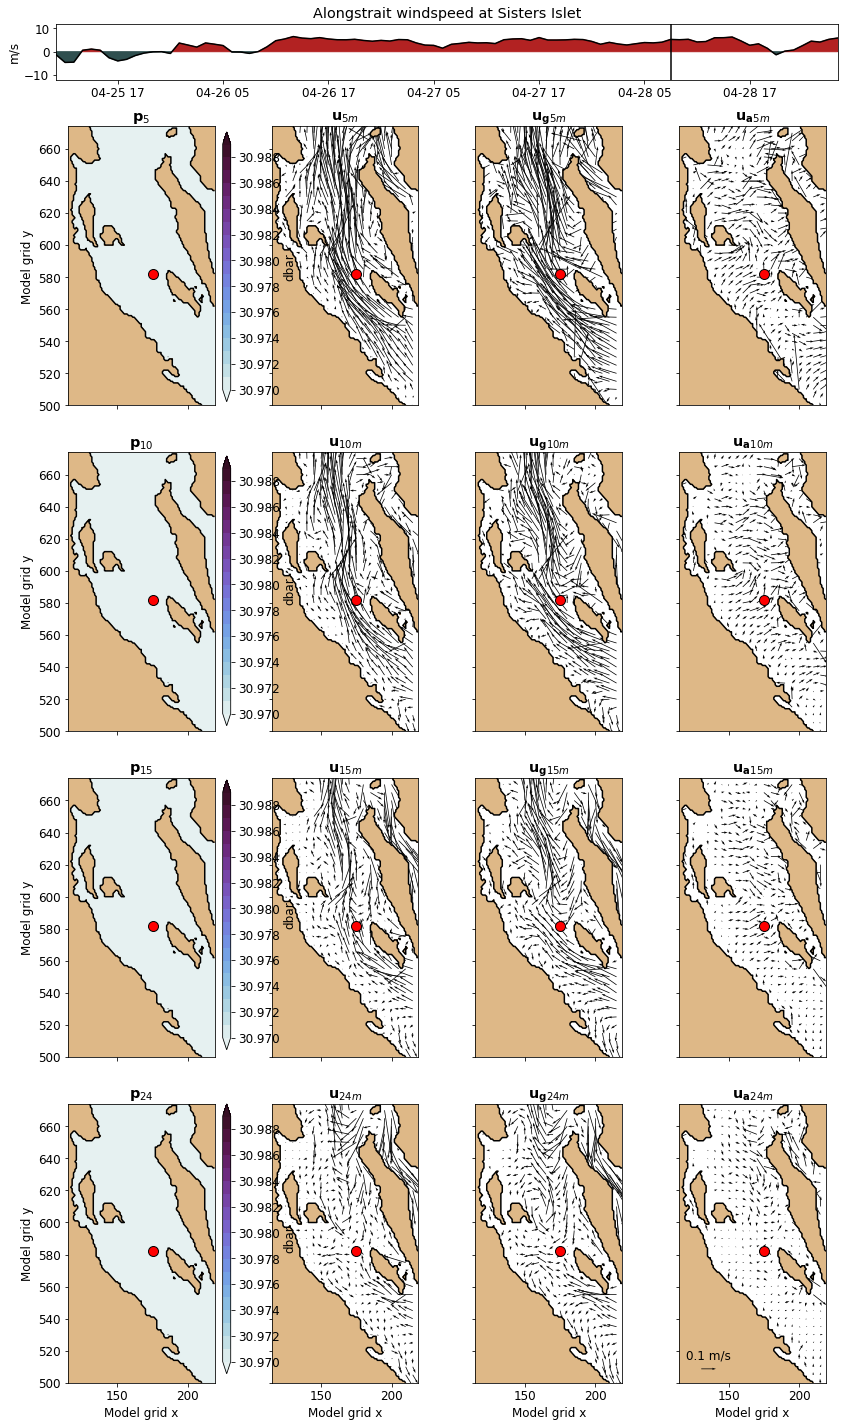

In [32]:
plotit(70)

### Idealized model results

In [26]:
rundir = '/data/bmoorema/MEOPAR/Results/SalishSeaPond/SalishSeaPond_basic_summer_S24H'
prefix = 'SalishSeaLake_1h_20170701_20170704'
T = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_T.nc'))
U = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_U.nc'))
V = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_V.nc'))
TRC = xr.open_dataset(os.path.join(rundir, f'{prefix}_ptrc_T.nc'))

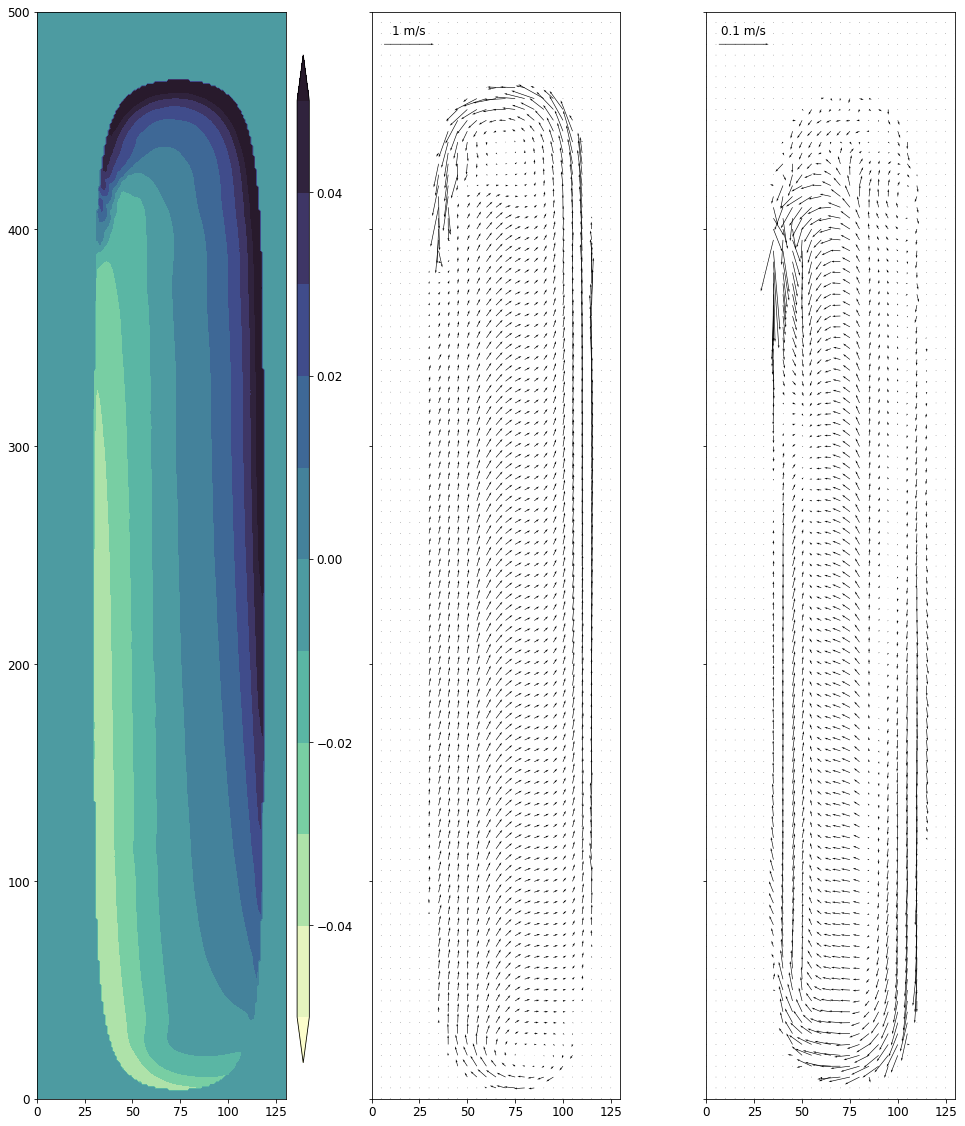

In [29]:
t = 40
fig, axs = plt.subplots(1, 3, figsize=(17, 20))
cax = fig.add_axes([0.35, 0.15, 0.01, 0.7])

c = axs[0].contourf(T.sossheig[t, ...], levels=np.arange(-0.05, 0.06, 0.01), cmap=cmocean.cm.deep, extend='both')

u, v = viz_tools.unstagger(U.vozocrtx[:, 0, ...].values, V.vomecrty[:, 0, ...].values)
q1 = axs[1].quiver(T.x[::5], T.y[::5], u[t, ::5, ::5], v[t, ::5, ::5], scale=5)

u, v = viz_tools.unstagger(U.vozocrtx[:, 24, ...].values, V.vomecrty[:, 24, ...].values)
q2 = axs[2].quiver(T.x[::5], T.y[::5], u[t, ::5, ::5], v[t, ::5, ::5], scale=0.5)

for ax, q, mag in zip(axs, [0, q1, q2], [0, 1, 0.1]):
    ax.set_xlim([0, 130])
    ax.set_ylim([0, 500])
    viz_tools.set_aspect(ax)
    if q != 0:
        ax.yaxis.set_ticklabels('')
        ax.quiverkey(q, 0.15, 0.97, mag, f'{mag} m/s')
    
fig.colorbar(c, cax=cax)

Text(0.5,1,'$\\mathbf{u_g}_{0.0001}$')

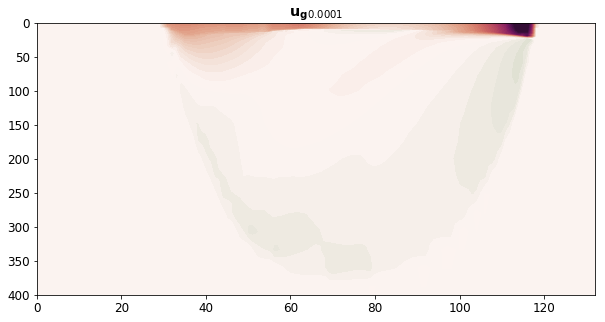

In [69]:
t = 40
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.contourf(V.x, V.depthv, V.vomecrty[t, :, 200, :], levels=np.arange(-0.5, 0.51, 0.01), cmap=cmocean.cm.curl, extend='both')
ax.set_ylim([400, 0])
ax.set_title(f'$\mathbf{{{u_lab}}}_{{{f}}}$')

In [ ]:
Ttest = xr.open_dataset('/data/bmoorema/MEOPAR/Results/SMELT_TRC_test/')